In [ ]:
import os
import json
import numpy as np
from sklearn.metrics import f1_score, hamming_loss, log_loss

# Path to the Hyperparameter folder
hyperparam_dir = "../model/Hypermeter_tuning/" 

results = []

# Looping through each models in the folder
for folder in os.listdir(hyperparam_dir):
    folder_path = os.path.join(hyperparam_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    
    preds_path = os.path.join(folder_path, "val_preds.npy")
    labels_path = os.path.join(folder_path, "val_labels.npy")
    
    if os.path.exists(preds_path) and os.path.exists(labels_path):
        y_pred = np.load(preds_path)
        y_true = np.load(labels_path)

        # Applying sigmoid for multi-label probabilities
        if y_pred.max() > 1 or y_pred.min() < 0:  # logits
            probs = 1 / (1 + np.exp(-y_pred))
        else:  # already probabilities
            probs = y_pred
        
        # Binarize predictions at 0.5 threshold
        y_bin = (probs >= 0.5).astype(int)

        # Computing the metrics
        try:
            macro_f1 = f1_score(y_true, y_bin, average='macro', zero_division=0)
            
            # Binary log loss (averaged over all labels)
            loss = log_loss(y_true.flatten(), probs.flatten(), labels=[0,1])
            
        except ValueError as e:
            print(f"Skipping {folder}: {e}")

# Sort by lowest log loss
results.sort(key=lambda x: x[1])

# Print results
for folder, loss, f1, acc in results:
    print(f"{folder}: val_loss = {loss:.4f}, macro_F1 = {f1:.4f}, subset_acc = {acc:.4f}")

if results:
    print("\nBest model:", results[0][0],
          "with loss =", results[0][1],
          "macro_F1 =", results[0][2],
          "subset_acc =", results[0][3])
else:
    print("No valid predictions found.")


best_model_lr2e-05_bs16_fold1: val_loss = 0.1056, macro_F1 = 0.3202, subset_acc = 0.9572
best_model_lr2e-05_bs8_fold2: val_loss = 0.1071, macro_F1 = 0.3079, subset_acc = 0.9572
best_model_lr2e-05_bs8_fold1: val_loss = 0.1072, macro_F1 = 0.2988, subset_acc = 0.9572
best_model_lr5e-05_bs16_fold2: val_loss = 0.1114, macro_F1 = 0.2826, subset_acc = 0.9572
best_model_lr5e-05_bs16_fold1: val_loss = 0.1123, macro_F1 = 0.2920, subset_acc = 0.9572
best_model_lr5e-05_bs8_fold2: val_loss = 0.1137, macro_F1 = 0.2522, subset_acc = 0.9572
best_model_lr5e-05_bs16_fold3: val_loss = 0.1590, macro_F1 = 0.0000, subset_acc = 0.9572
best_model_lr5e-05_bs8_fold3: val_loss = 0.1590, macro_F1 = 0.0000, subset_acc = 0.9572
best_model_lr5e-05_bs8_fold1: val_loss = 0.1596, macro_F1 = 0.0000, subset_acc = 0.9572

Best model: best_model_lr2e-05_bs16_fold1 with loss = 0.10555851913094037 macro_F1 = 0.3202124172970803 subset_acc = 0.9571629647961394


## LIME to interpret the model

In [16]:
import torch
import numpy as np
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer

In [9]:
# loading the best model
model_path = "../model/Hypermeter_tuning/best_model_lr2e-05_bs16_fold1"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please 

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [11]:
def predict_proba(texts):
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    
    with torch.no_grad():
        logits = model(**encodings).logits.cpu().numpy()
    
    # Multi-label probabilities
    probs = 1 / (1 + np.exp(-logits))
    return probs

In [12]:
val_texts = [
    "I am very happy today!",
    "This is so disappointing...",
    "Feeling grateful and blessed.",
    "I am worried about tomorrow.",
    "That was hilarious!",
    "I feel a deep sadness inside me.",
    "The support from my friends is amazing.",
    "I can’t believe this happened!",
    "This is frustrating and annoying.",
    "Love and joy fill my heart today."
]

In [13]:
# Lime Explainer setup
class_names = [f"Label_{i}" for i in range(model.config.num_labels)]
explainer = LimeTextExplainer(class_names=class_names)

In [18]:
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]


Sample 1: Feeling grateful and blessed.
Top predicted emotion: gratitude (prob=0.6319)


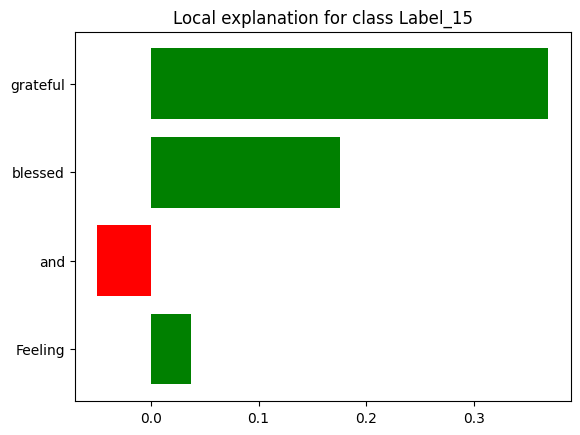


Sample 2: I am worried about tomorrow.
Top predicted emotion: nervousness (prob=0.3427)


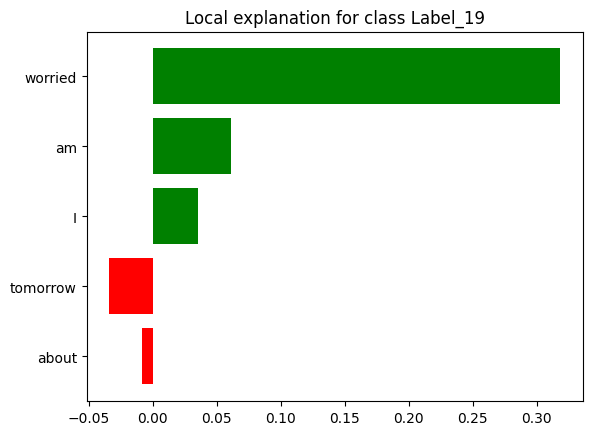


Sample 3: The support from my friends is amazing.
Top predicted emotion: admiration (prob=0.7610)


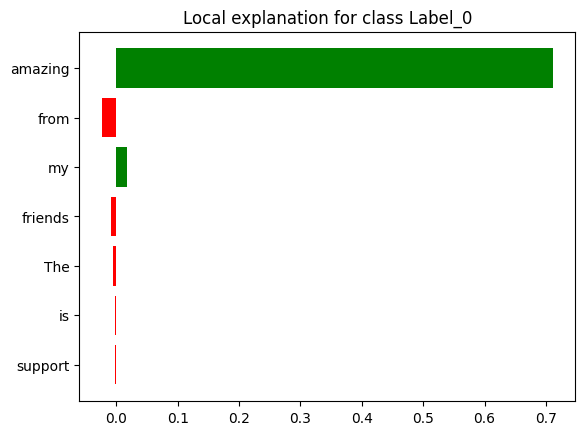


Sample 4: That was hilarious!
Top predicted emotion: amusement (prob=0.7419)


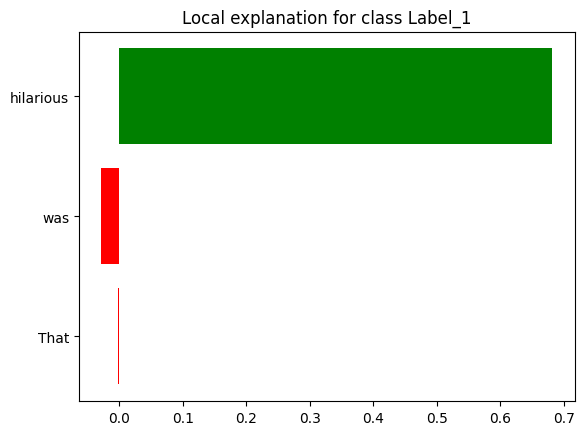


Sample 5: This is so disappointing...
Top predicted emotion: disappointment (prob=0.8574)


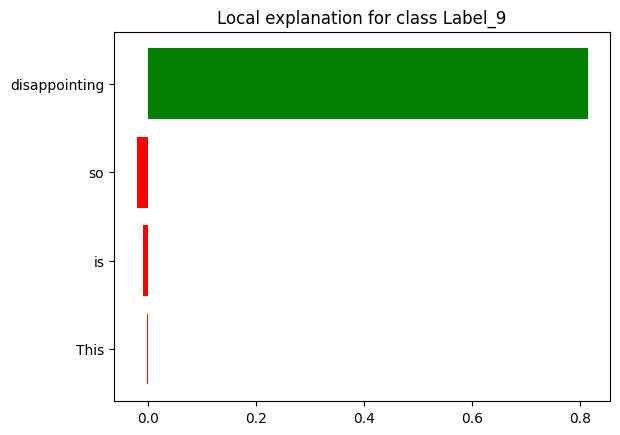


Sample 6: I feel a deep sadness inside me.
Top predicted emotion: sadness (prob=0.8502)


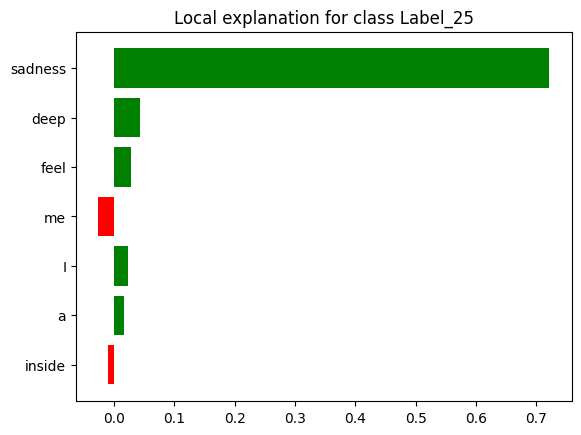


Sample 7: I am very happy today!
Top predicted emotion: joy (prob=0.7207)


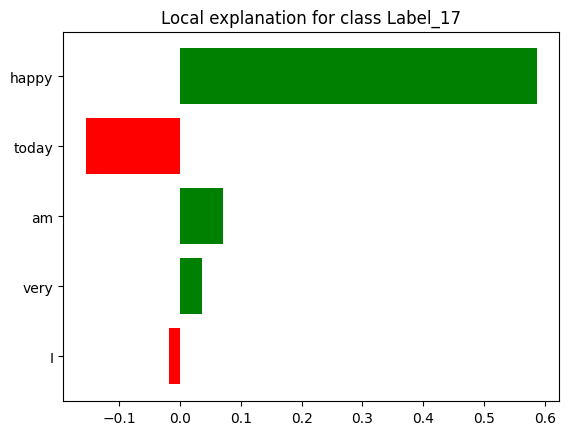


Sample 8: Love and joy fill my heart today.
Top predicted emotion: love (prob=0.6501)


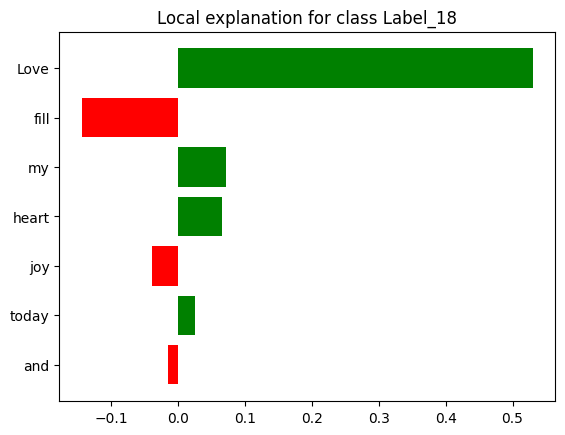


Sample 9: This is frustrating and annoying.
Top predicted emotion: annoyance (prob=0.8422)


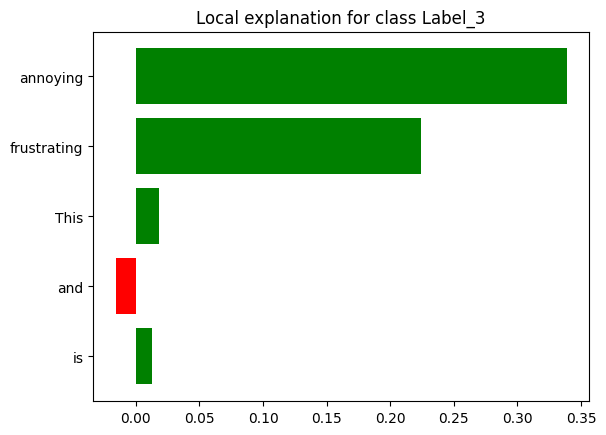


Sample 10: I can’t believe this happened!
Top predicted emotion: surprise (prob=0.4629)


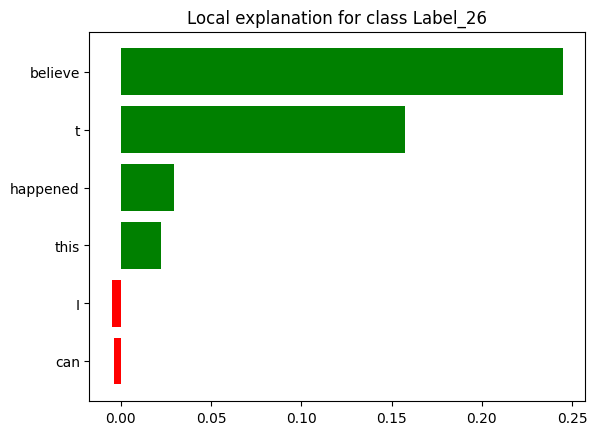

In [19]:
import matplotlib.pyplot as plt
sample_texts = random.sample(val_texts, min(10, len(val_texts)))

for i, text in enumerate(sample_texts, 1):
    print(f"\nSample {i}: {text}")

    # Get model prediction for this text
    probs = predict_proba([text])[0]
    top_label = np.argmax(probs)  # pick top predicted label

    # Explain top label
    exp = explainer.explain_instance(
        text,
        predict_proba,
        labels=(top_label,),
        num_features=8,   # top 8 words
        num_samples=200   # fewer for speed
    )

    print(f"Top predicted emotion: {emotion_columns[top_label]} (prob={probs[top_label]:.4f})")
    
    fig = exp.as_pyplot_figure(label=top_label)
    plt.show()